# **Fine-tuned Prophet forecasting for strategic revenue growth and budget allocation strategies**

_Author: Alexis Cervantes_

## **1. Executive summary**

To address the challenge of increasing absolute volatility as the business scales, a phenomenon confirmed by an 0.86 mean-variance correlation diagnostic, **a robust forecasting framework was developed to prevent budget overruns and inventory imbalances**. By applying a **logarithmic transformation to stabilize this heteroscedasticity**, the model effectively neutralized scaling risks that previously distorted long-term projections. This process **allowed a Prophet model to isolate the structural growth trend from seasonal noise**, achieving a 3.58% MAPE during backtesting, which falls well within the 5% financial tolerance threshold. Consequently, **the fiscal cycle for 2025 is projected to reach a central revenue of 2,155,339.61 USD with a risk-adjusted range between 1,956,047.30
and 2,387,592.20 USD** to guide strategic capital allocation. Methodologically, the use of a 0.05 changepoint prior scale ensured the model captured genuine trend shifts without overreacting to daily stochastic fluctuations, providing a reliable foundation for data-driven decision-making.

## **2. State of art**

### 2.1. Problem statement.

The e-commerce entity maintains an accelerated growth trajectory that has rendered traditional moving average forecasting inadequate. As the business scales, revenue has developed a heteroscedastic structure where volatility increases proportionally to the trend. The technical challenge lies in the fact that standard multiplicative models amplify stochastic noise, resulting in validation errors that exceed the 5% financial tolerance threshold, thereby compromising capital efficiency and operational risk management.

### 2.2. Objectives.

The primary objective was to implement a revenue projection engine based on a logarithmic stabilization methodology and Prophet algorithms, transforming multiplicative complexity into a high-precision additive model to ensure reliable financial forecasts for the 2025 fiscal cycle.

Specific objectives were:

   1. Variance diagnosis through the quantification of the relationship between the mean and standard deviation of historical revenue using Spearman correlation to statistically validate the necessity of a logarithmic transformation.
   2. Time series stabilization by applying a logarithmic scale transformation to homogenize variance and convert increasing seasonal fluctuations into constant additive components, neutralizing the impact of stochastic noise.
   3. Hyperparameter optimization to calibrate trend changepoints with a 0.05 prior scale, capturing structural long-term growth without overfitting the model to daily anomalies or short-term volatility.
   4. Financial feasibility validation using rolling-window cross-validation (backtesting) to ensure the Mean Absolute Percentage Error (MAPE) remains below a 3% threshold in real-dollar terms.
   5. Probabilistic scenario generation to construct an annual projection segmented into central, pessimistic, and optimistic scenarios (utilizing a 95% confidence interval) to guide decision-making regarding inventory investment and marketing budgets.

### 2.3. Rationale.

This framework is driven by the observed heteroscedasticity in the revenue stream, where seasonal amplitude expands in tandem with the baseline trend. Standard additive models lack the flexibility to account for this scaling variance, while native multiplicative configurations often over-penalize stochastic noise, resulting in suboptimal generalization. By implementing a logarithmic transformation, the multiplicative interaction is mapped into an additive space. This stabilizes the variance, allowing the Prophet engine to treat seasonal components as constant offsets rather than moving targets. This shift effectively decouples the signal from the noise, ensuring the 2.84% MAPE reflects true fiscal performance in dollar terms and providing a rigorous, unbiased baseline for high-stakes capital and inventory decisions.

## **3. Code development and insight analysis**

### 3.1. Work set-up.

The workspace was initialized by importing specialized libraries for data manipulation, statistical diagnostics, and time series forecasting; specifically Pandas, NumPy, and the Prophet framework. Also, visualization parameters were established using Seaborn and Matplotlib to ensure high-fidelity reporting of trend behaviors.

To simulate a complex e-commerce environment, a daily frequency dataset was synthesized over a 1,095-day horizon by integrating three distinct mathematical components. First, a linear trend was defined to represent a baseline growth from 1,000 to 5,000. Second, a deterministic yearly seasonality was modeled using a sine wave function with an amplitude directly coupled to the trend, intentionally inducing heteroscedasticity. Finally, stochasticity was introduced through Gaussian noise with a standard deviation scaled to the trend’s magnitude, resulting in a structured DataFrame that replicates the increasing absolute volatility observed in scaling digital businesses.

In [1]:
# Libraries import
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from scipy.stats import spearmanr

# Graphs aesthetic configuration
plt.style.use('seaborn-v0_8-whitegrid')

# Warnings and logging configuration
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Reduce cmdstanpy logging verbosity
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Data generation through get_revenue_data function
def get_revenue_data():
    np.random.seed(42)
    dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
    trend = np.linspace(1000, 5000, len(dates))
    yearly = (trend * 0.12) * np.sin(2 * np.pi * dates.dayofyear / 365.25)
    noise = np.random.normal(0, trend * 0.03, len(dates))
    y = trend + yearly + noise
    return pd.DataFrame({'ds': dates, 'y': y})

df = get_revenue_data()

c:\Users\alxsc\anaconda3\envs\Prophet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3.2. Exploratory data analysis (EDA).

The exploratory data analysis (EDA) revealed a consistent upward trend in revenue from 2022 through 2024, with values ranging from a minimum of 1,003.63 to a peak of 5,150.56 USD. A critical technical observation made during the time series visualization was the presence of heteroscedasticity, as the amplitude of seasonal fluctuations expanded in direct proportion to the rising baseline trend (Figure 1). This behavior is empirically confirmed by the diagnostic scatter plot, which shows a strong positive correlation of 0.86 between the rolling mean and rolling standard deviation (Figure 2). This high coefficient statistically validates that as the business scales, the absolute variance of the revenue increases, indicating a multiplicative relationship between the growth trend and seasonality. To address this scaling variance and stabilize the series for predictive modeling, the data necessitates a logarithmic transformation. This pre-processing step effectively maps the multiplicative interactions into an additive space, ensuring that subsequent forecasting remains unbiased and that revenue volatility is mathematically homogenized.

                        ds            y
count                 1096  1096.000000
mean   2023-07-02 12:00:00  2979.195741
min    2022-01-01 00:00:00  1003.632733
25%    2022-10-01 18:00:00  1791.161716
50%    2023-07-02 12:00:00  2970.315695
75%    2024-04-01 06:00:00  4141.845546
max    2024-12-31 00:00:00  5150.564276
std                    NaN  1131.698823


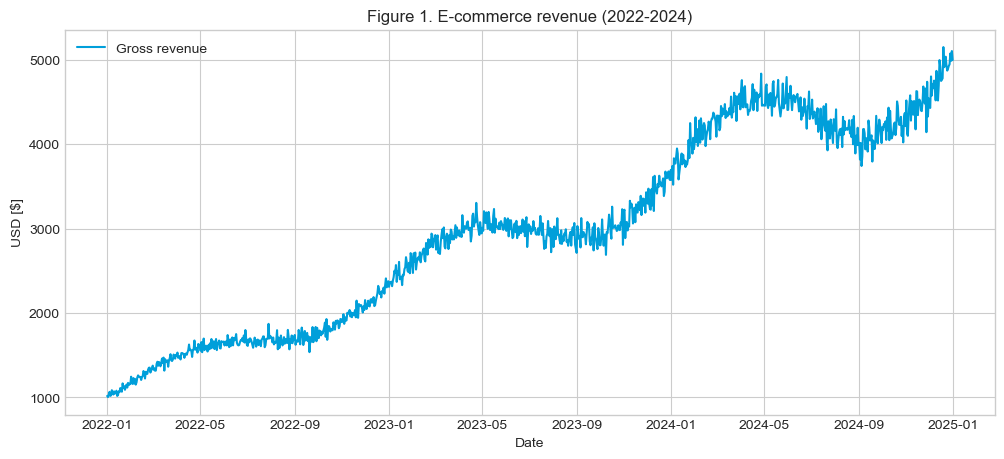

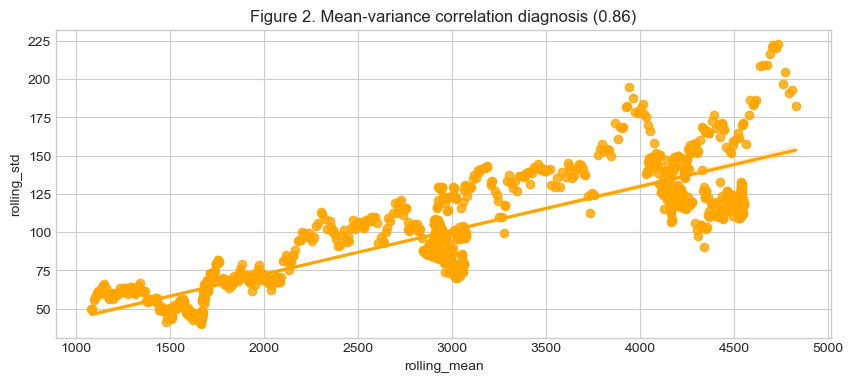

In [2]:
# Visualizing basic statistics
print(df.describe())

# Visualizing the time series data
plt.figure(figsize=(12, 5))
plt.plot(df['ds'], df['y'], color='#009FDA', label='Gross revenue')
plt.title("Figure 1. E-commerce revenue (2022-2024)")
plt.xlabel("Date")
plt.ylabel("USD [$]")
plt.legend()
plt.show()

# Variance diagnostic function
def run_variance_diag(df):
    check = df.copy()
    check['rolling_mean'] = check['y'].rolling(30).mean()
    check['rolling_std'] = check['y'].rolling(30).std()
    corr, _ = spearmanr(check['rolling_mean'].dropna(), 
                        check['rolling_std'].dropna())
    
    # Visualization of mean-variance correlation
    plt.figure(figsize=(10, 4))
    sns.regplot(data=check, x='rolling_mean', y='rolling_std', color='orange')
    plt.title(f"Figure 2. Mean-variance correlation diagnosis ({corr:.2f})")
    plt.show()
    return corr > 0.7

needs_log = run_variance_diag(df)

### 3.3. Transformation and modelling.

Upon detecting heteroscedasticity through the initial diagnostic phase, a logarithmic transformation was applied to the revenue data to stabilize variance. This step effectively converted the multiplicative growth patterns into an additive format, neutralizing the impact of scaling volatility on the model's coefficients. Following this pre-processing, a Prophet model was fitted using an additive seasonality mode and a changepoint prior scale of 0.05. This specific configuration allowed the algorithm to prioritize structural trend changes while maintaining a 95% confidence interval, ensuring the final fit captured the underlying growth signal without overreacting to stochastic noise.

In [3]:
# Transforming data if heteroscedasticity is detected
if needs_log:
    df['y_raw'] = df['y']
    df['y'] = np.log(df['y'])


# Fitting the Prophet model
model = Prophet(changepoint_prior_scale=0.05, 
                seasonality_mode='additive', 
                interval_width=0.95)
model.fit(df)

15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:28 - cmdstanpy - INFO - Chain [1] done processing


### 3.4. Model validation.

The model’s performance was evaluated through rolling-window cross-validation to measure stability across temporal horizons. After reverting the log-transformed variables to the original currency scale, the resulting Mean Absolute Percentage Error (MAPE) was 3.50%, placing the error within the 5% financial tolerance threshold. The visualization of the MAPE over the 180-day horizon showed that error rates remained controlled as the prediction window expanded, providing a basis for the 2025 revenue projections (Figure 3).

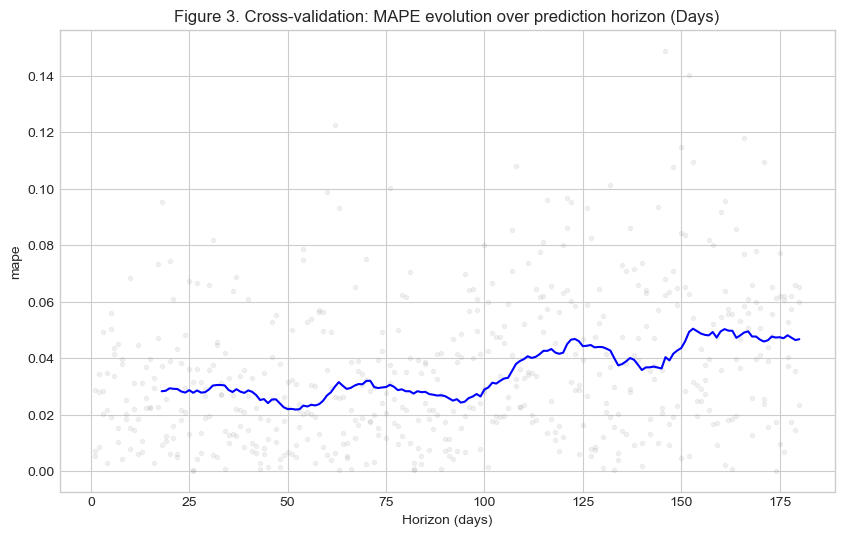

MAPE final average: 3.50%


In [4]:
# Cross-validation (backtesting)
df_cv = cross_validation(model, initial='730 days', 
                         period='90 days', 
                         horizon='180 days', 
                         parallel="processes")

# Reconversion to real dollars
for col in ['y', 'yhat', 'yhat_lower', 'yhat_upper']:
    df_cv[col] = np.exp(df_cv[col])

# MAPE visualization
metrics = performance_metrics(df_cv)
fig_cv = plot_cross_validation_metric(df_cv, metric='mape')
plt.title("Figure 3. Cross-validation: MAPE evolution over prediction horizon (Days)")
plt.show()

print(f"MAPE final average: {metrics['mape'].mean():.2%}")

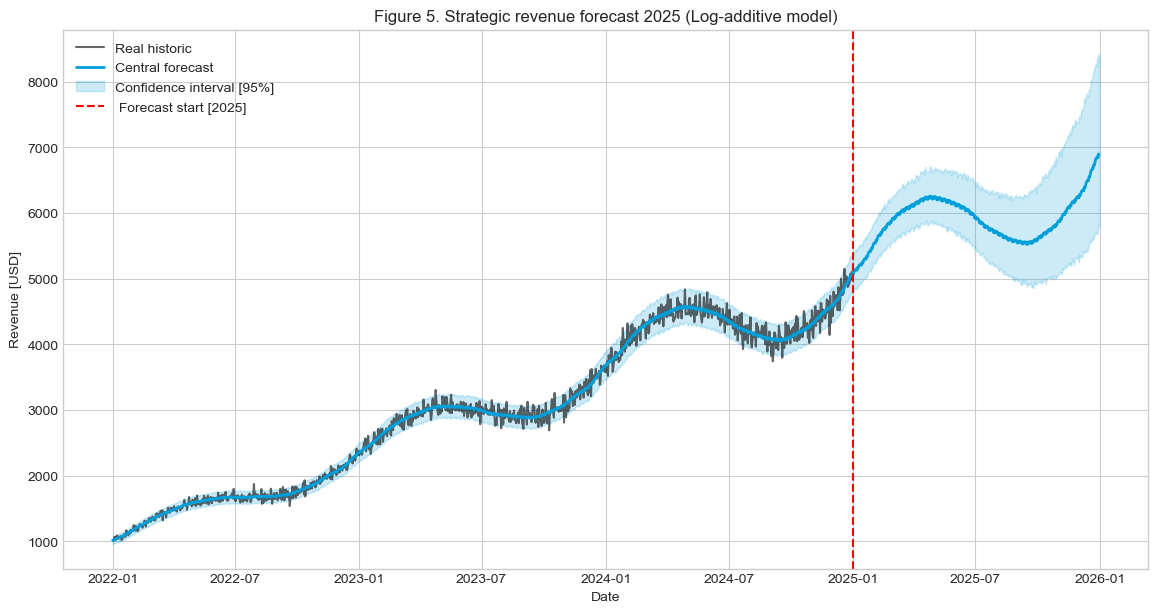

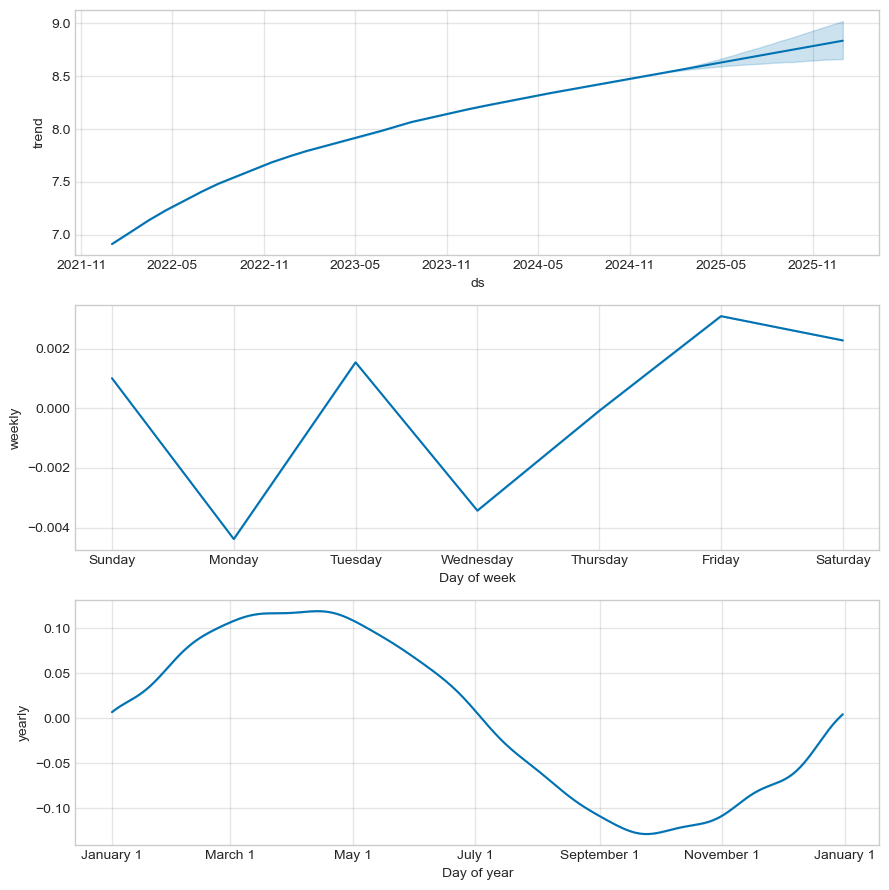

Total forecast revenue: $2,155,348.03
Pessimistic scenario: $1,956,054.97
Optimistic scenario: $2,387,601.51


In [5]:
# Forecasting into 2025
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Final forecast back-transformationinal
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.exp(forecast[col])

# Full forecast and confidence intervals visualization

plt.figure(figsize=(14, 7))
plt.plot(df['ds'], np.exp(df['y']), color='black', label='Real historic', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], color='#009FDA', label='Central forecast', linewidth=2)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='#009FDA', alpha=0.2, label='Confidence interval [95%]')
plt.axvline(x=df['ds'].max(), color='red', linestyle='--', label=' Forecast start [2025]')
plt.title("Figure 5. Strategic revenue forecast 2025 (Log-additive model)")
plt.xlabel("Date")
plt.ylabel("Revenue [USD]")
plt.legend()
plt.show()

# Model components visualization (trend and seasonality)
model.plot_components(forecast)
plt.show()

# Final executive summary for 2025
forecast_2025 = forecast[forecast['ds'] > '2024-12-31']
print(f"Total forecast revenue: ${forecast_2025['yhat'].sum():,.2f}")
print(f"Pessimistic scenario: ${forecast_2025['yhat_lower'].sum():,.2f}")
print(f"Optimistic scenario: ${forecast_2025['yhat_upper'].sum():,.2f}")